This notebook will explain how to use the ADMM.

Basically, the core of the algorithm is inside the ADMM class (admm.py). The constructor takes as input all the initial parameters, then the method iterate will run the algorithm. However, there is a lot of parameters and some pre-processing needed that we will detail here.

In [1]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
from astropy.io import fits as fits
import matplotlib.pylab as plt



In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as backk

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# This line is optional, don't add it unless you really need to set a limit on the memory available for your process
# For instance, if you want to train 2 DNNs on the same GPU without one overlapping the memory needed by the other
# Change the value to set the percentage of memory allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.47 

# Create a session with the above options specified.
backk.tensorflow_backend.set_session(tf.Session(config=config))

# Now you can create/load your DNN

Using TensorFlow backend.


In [3]:
from DeepDeconv.deepnet.DeepNet import DeepNet
from DeepDeconv.admm.admm_FCS import ADMM_deconv
from DeepDeconv.admm.admm import ADMM
from DeepDeconv.utils.batch_utils import admm_data
from DeepDeconv.utils.conv_utils import recenter_psf

First, we initialise the hyper parameters:

Then you need to instanciate the network used for denoising

In [4]:
#model_file = '/data/DeepDeconv/model/Denoiser_net_vsc_swish_noise0p04.hdf5'
model_file= '/data/DeepDeconv/model/DenoiserNet_vsc_noise0p04.hdf5'

dnn = DeepNet(network_name='ADMM net', model_file=model_file)

Loadind model...
/data/DeepDeconv/model/DenoiserNet_vsc_noise0p04.hdf5


At last, we need the data to deconvolve. The algorithm need the image to deconvolve, the PSF and the standard deviation of the noise sigma.

A function admm_data is available to generates data from fits files similar to those used for the neural network.

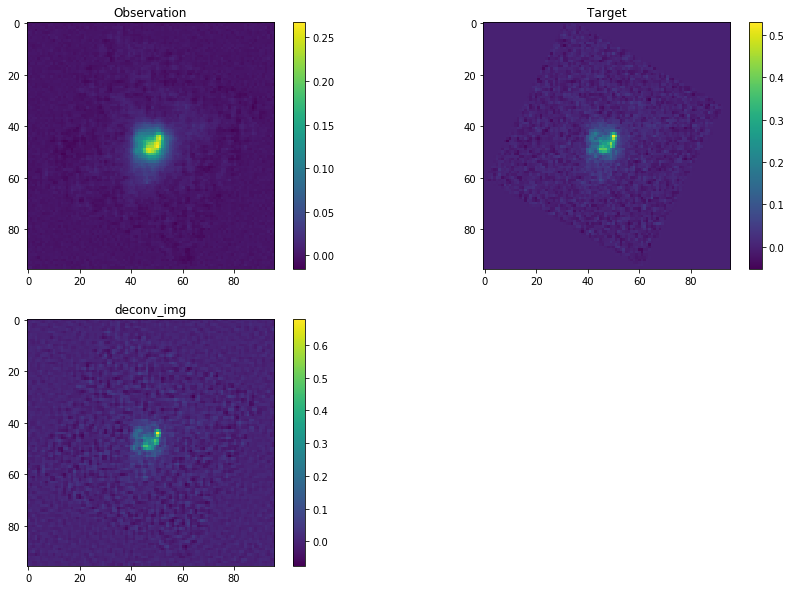

In [5]:
testset_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
testset_file = 'image-shfl-0-multihdu.fits'
#fits_file = '/data/DeepDeconv/data/vsc_euclidpsfs/image-000-0.fits'
fits_file = testset_path+testset_file
idx = 0 #idx of the galaxy (between 0 and 9999 for our files)
SNR = 1000 #we add noise such as the SNR is 50
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
risktype="GCV"
reg="Dirac"
reg_frac=1.0
tol=1e-12
observation, target, psf, snr_img, noise_std,deconv_img,hyp = admm_data(fits_file, idx, noise_std=None, SNR=SNR,
                                                         noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                                                         image_dim=96, image_per_row=100,deconv_mode='TIKHONOV_HYP',
                                                                       risktype=risktype,reg=reg,tol=tol)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(observation)
plt.colorbar()
plt.title('Observation')
plt.subplot(222)
plt.imshow(target)
plt.colorbar()
plt.title('Target')
plt.subplot(223)
plt.imshow(deconv_img)
plt.colorbar()
plt.title('deconv_img')

plt.show()

All that is left is to instanciate the ADMM and run it.

In [6]:
#PARAMETERS ADMM
max_iter = 20 #maximal number of iterations
gamma = 1.4 #value of gamma used for the update of rho
rho = 200 #initial value of rho
rho_cap = 200 #higher limit of rho. 
eta = 0.5 #value of eta which determines the update rule of rho
opti_method = 'TIKHONOV' #chose between 'FISTA' or 'GD' (gradient descent) for the inversion step
psf_rectr=recenter_psf(psf,np.array([-0.5,-0.5]))

In [7]:
import timeit

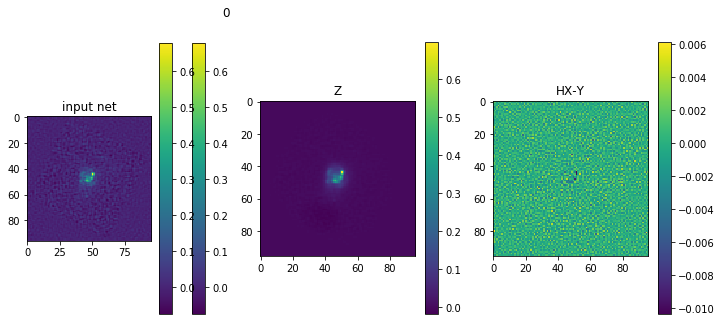

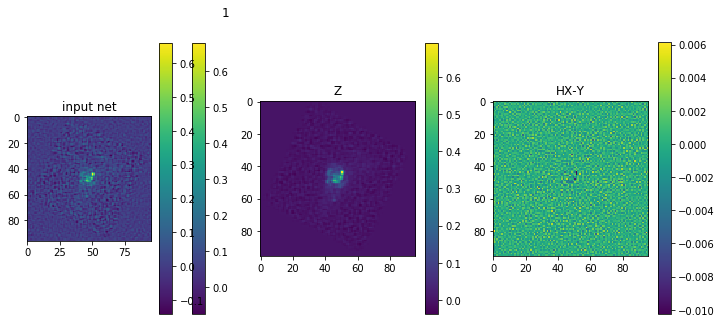

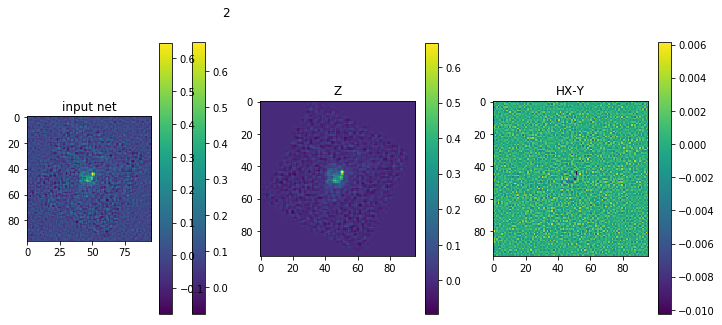

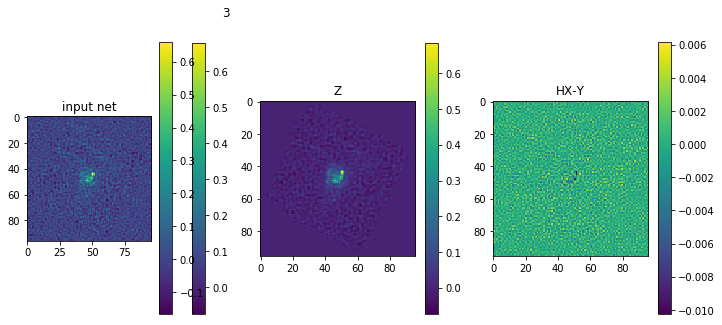

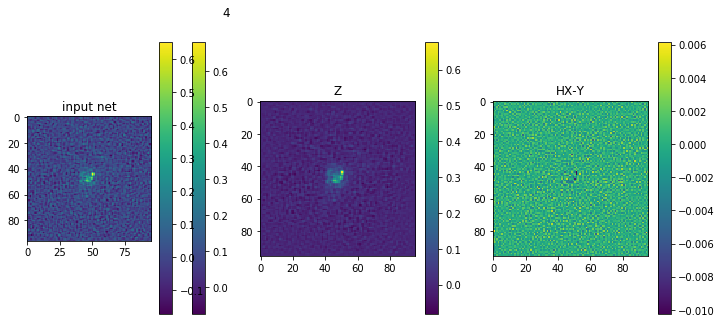

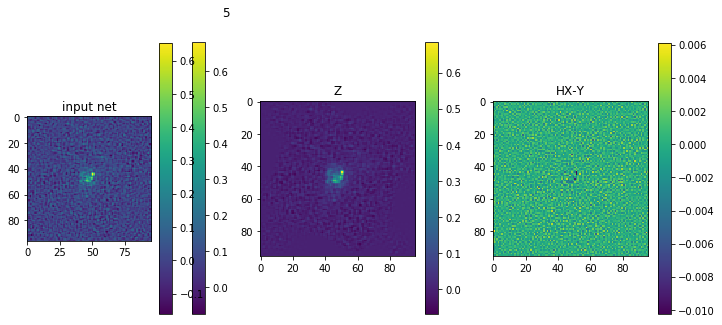

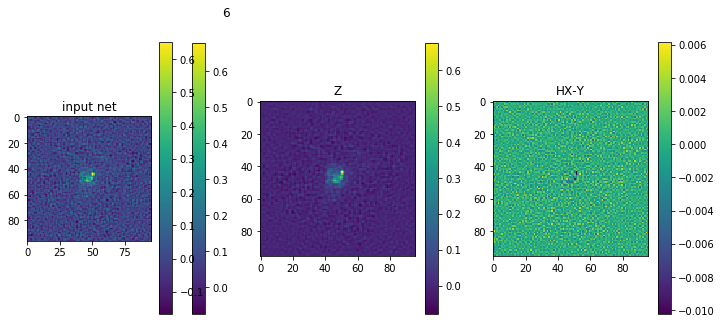

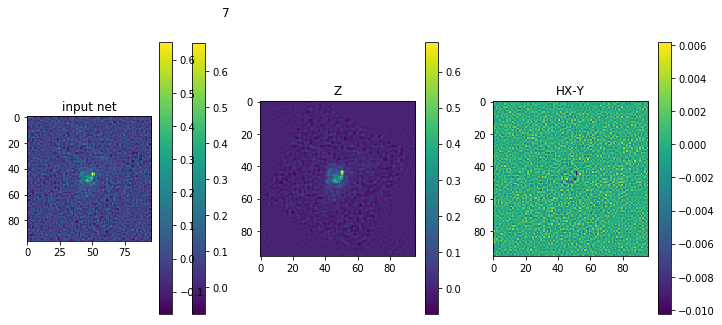

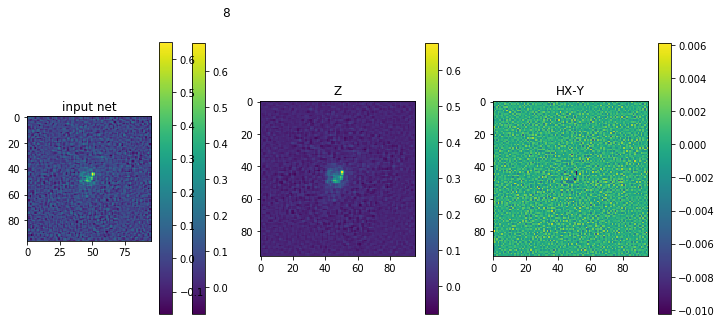

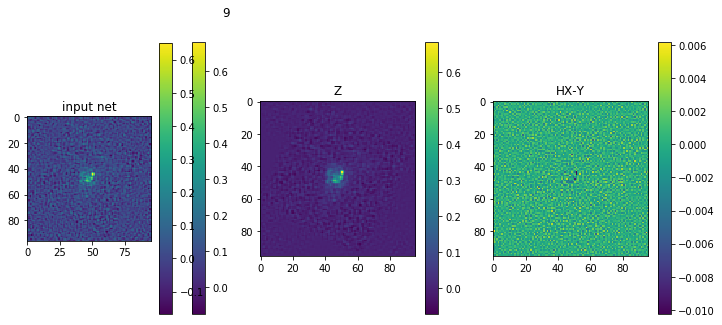

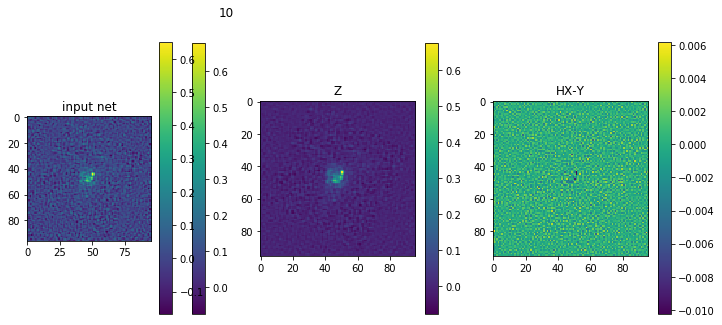

ADMM= 12.481198769062757


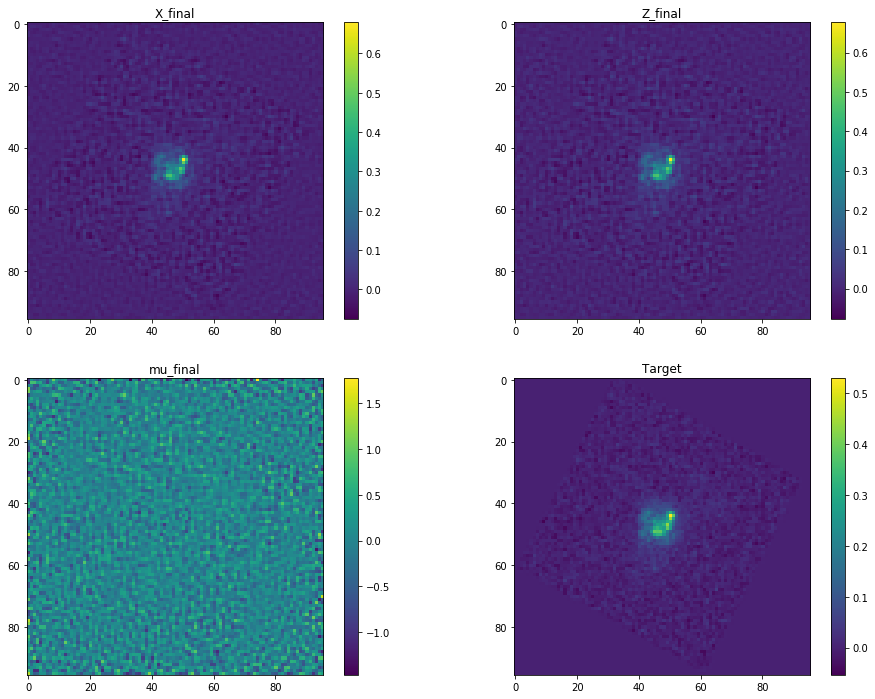

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcc21720320>,
 Text(0.5, 1.0, 'Target'),
 None)

In [14]:
rho = 10 #initial value of rho
mu = np.zeros((96,96))
x = np.zeros((96,96))
z = np.zeros((96,96))
rho_cap = rho #higher limit of rho. 
tic = timeit.default_timer()
ad = ADMM_deconv(x, z, mu, observation, psf_rectr, noise_std, dnn, rho=rho, rho_cap=rho_cap, gamma=gamma, eta=eta,
                  opti_method=opti_method,quad_prior=hyp/(noise_std*noise_std))

ad.iterate(max_iter=10, plot_iter=1, verbose=False, plot_verbose=True)
toc = timeit.default_timer()
print("ADMM=",toc-tic)
plt.figure(figsize=(16,12))
plt.subplot(221),plt.imshow(ad.x_final),plt.title('X_final'),plt.colorbar()
plt.subplot(222),plt.imshow(ad.z_final),plt.title('Z_final'),plt.colorbar(),
plt.subplot(223),plt.imshow(ad.mu_final),plt.title('mu_final'),plt.colorbar()
plt.subplot(224),plt.imshow(target),plt.title('Target'),plt.colorbar(),plt.show()


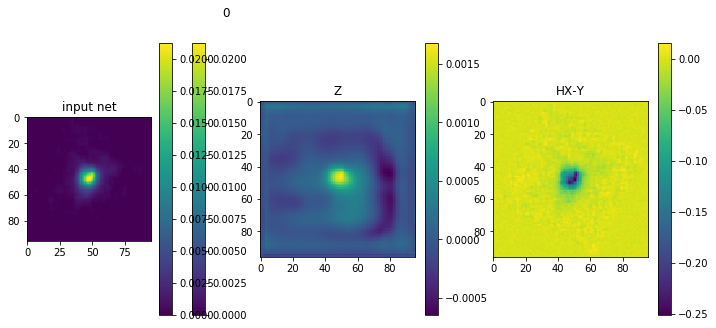

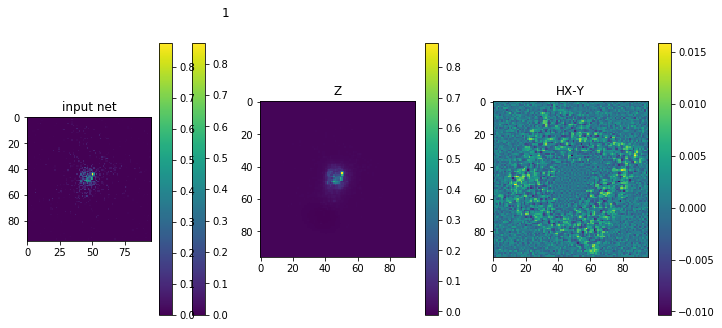

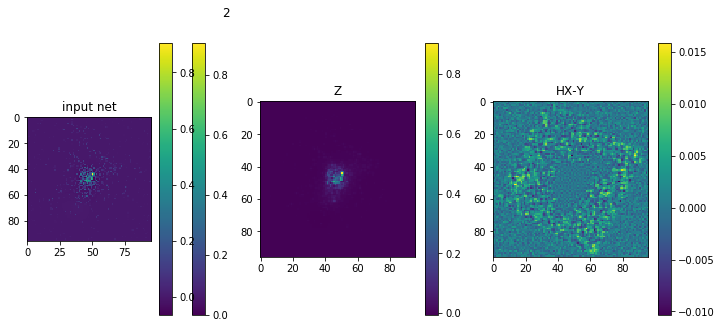

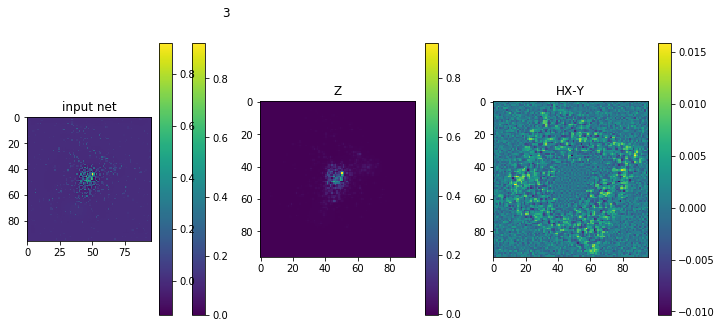

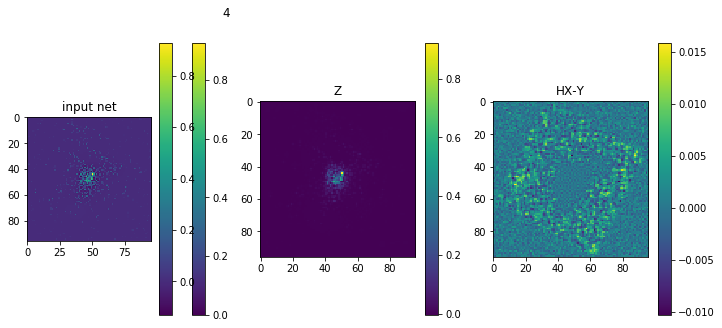

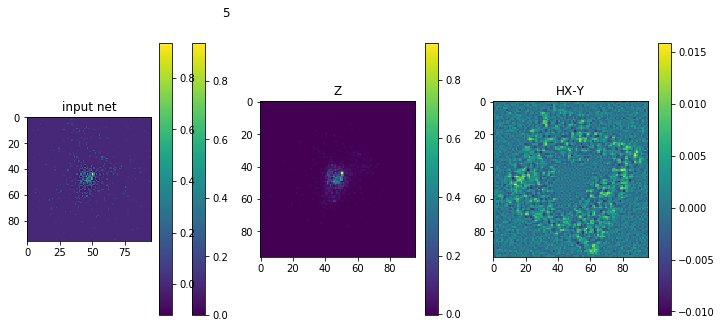

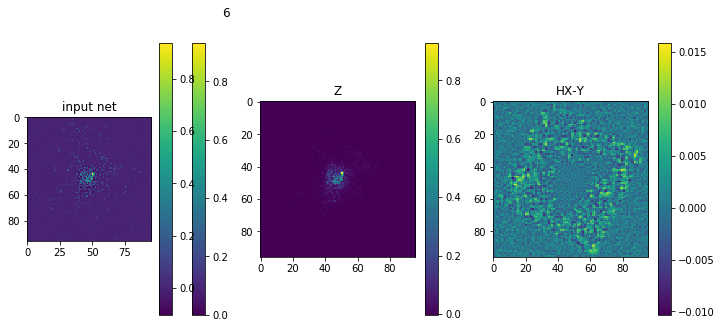

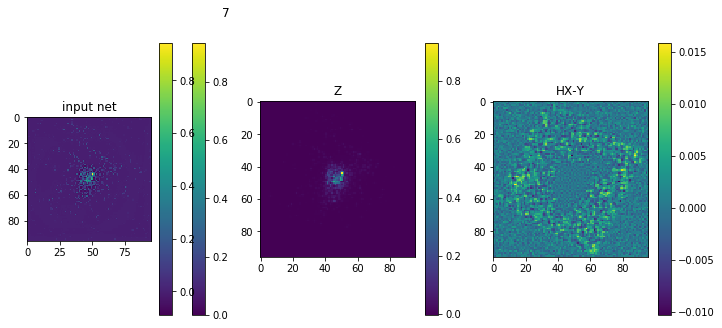

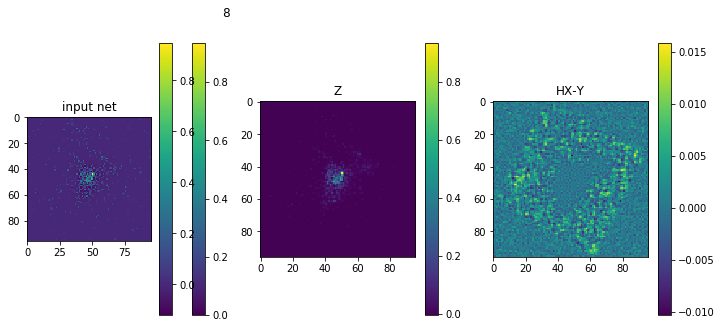

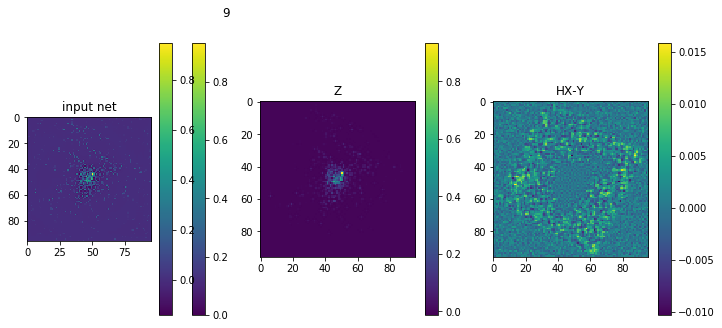

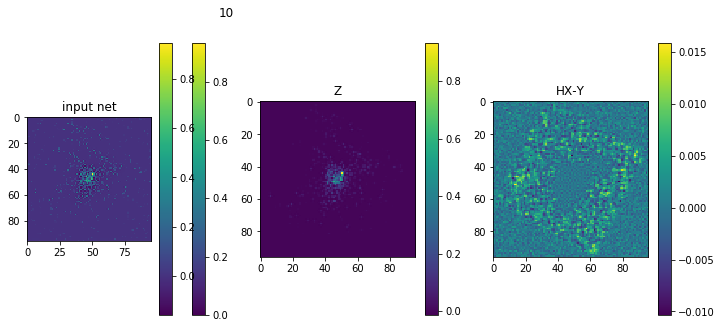

ADMM= 32.95981395430863


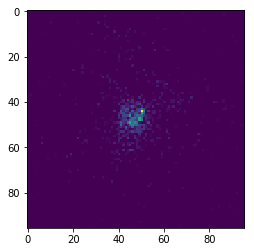

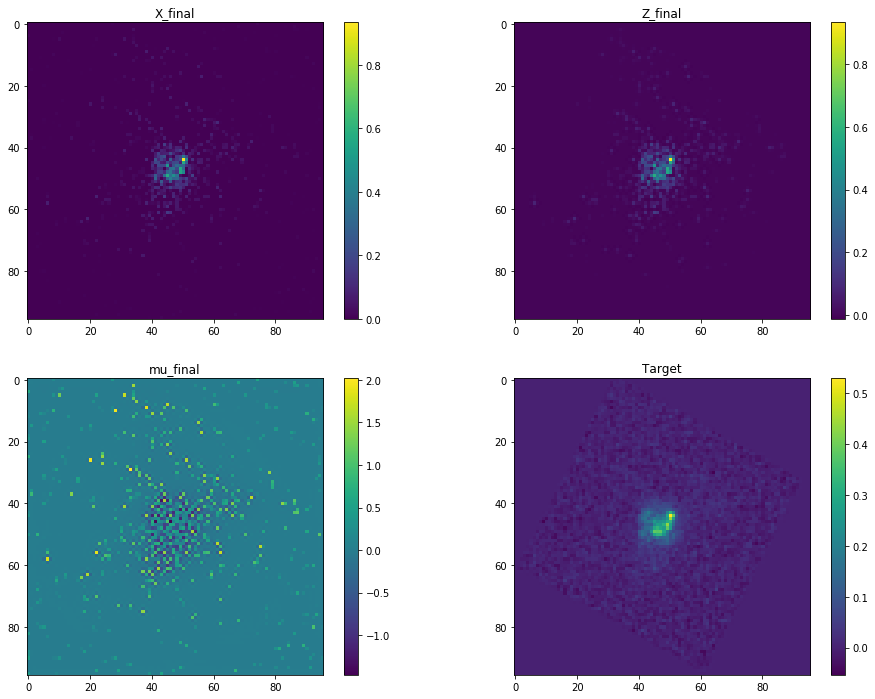

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcc58af2be0>,
 Text(0.5, 1.0, 'Target'),
 None)

In [20]:
tic = timeit.default_timer()
rho = 1 #initial value of rho
mu = np.zeros((96,96))
x = np.zeros((96,96))
z = np.zeros((96,96))
ad = ADMM_deconv(x, z, mu, observation, psf_rectr, noise_std, dnn, rho=rho, rho_cap=rho_cap, gamma=gamma, eta=eta,
                  opti_method="FISTA")
ad.iterate(max_iter=10, plot_iter=1, verbose=False, plot_verbose=True)
toc = timeit.default_timer()
print("ADMM=",toc-tic)
plt.imshow(ad._fista())

plt.figure(figsize=(16,12))
plt.subplot(221),plt.imshow(ad.x_final),plt.title('X_final'),plt.colorbar()
plt.subplot(222),plt.imshow(ad.z_final),plt.title('Z_final'),plt.colorbar(),
plt.subplot(223),plt.imshow(ad.mu_final),plt.title('mu_final'),plt.colorbar()
plt.subplot(224),plt.imshow(target),plt.title('Target'),plt.colorbar(),plt.show()


(<matplotlib.image.AxesImage at 0x7ff3ddf95940>,
 <matplotlib.colorbar.Colorbar at 0x7ff3dfe1b2b0>)

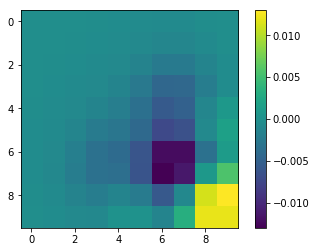

In [40]:
from DeepDeconv.utils.conv_utils import get_conv2d_fftconv, get_conv2d
hth = get_conv2d_fftconv(psf_rectr, psf_rectr, mode='scipy_fft', transp=True)
psf_dectr=recenter_psf(psf,np.array([0,0]))
hth2= get_conv2d(psf_dectr, psf_dectr, mode='scipy_fft', transp=True)
plt.imshow((hth-hth2)[40:50,40:50]),plt.colorbar()


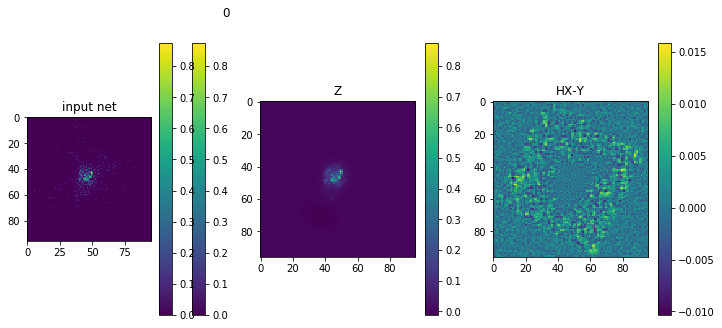

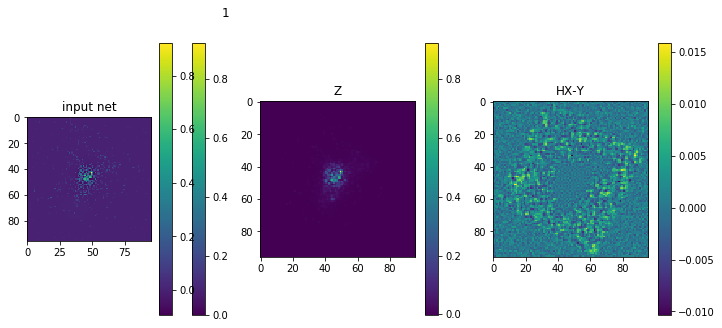

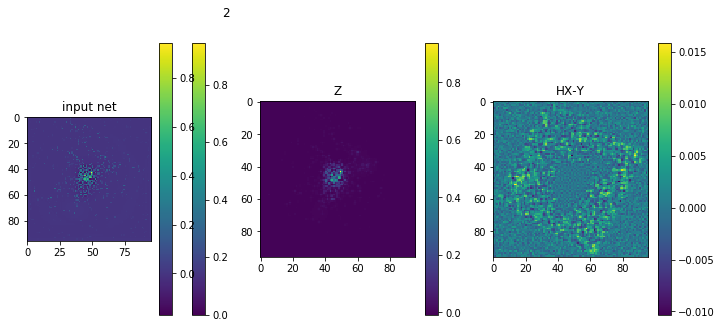

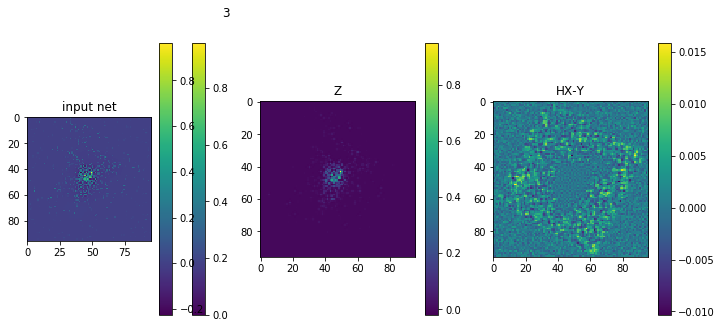

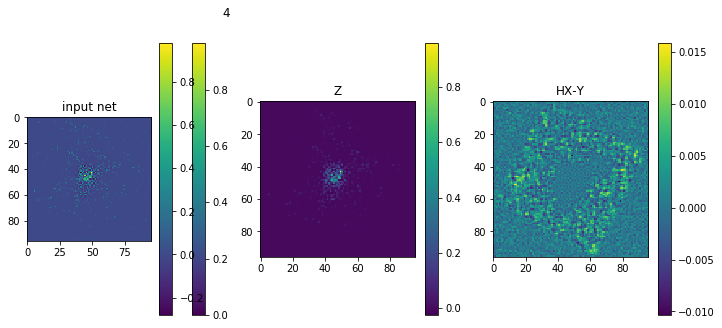

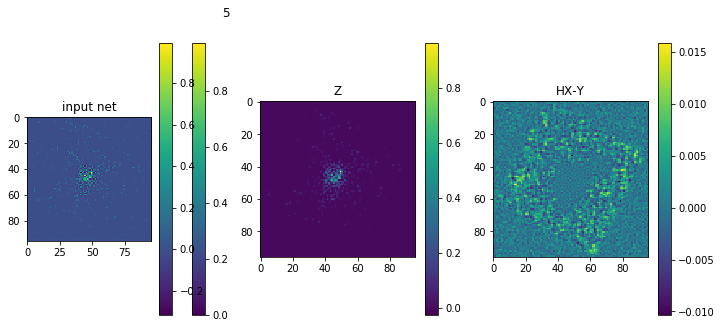

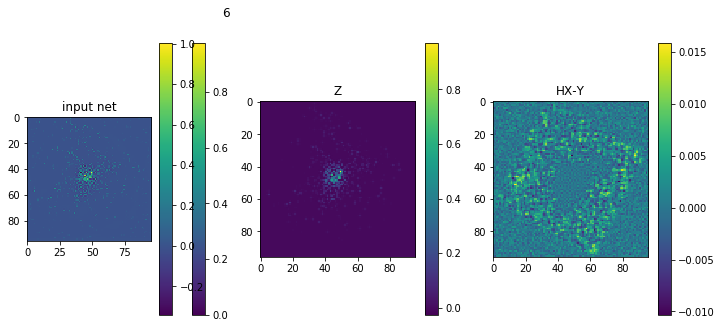

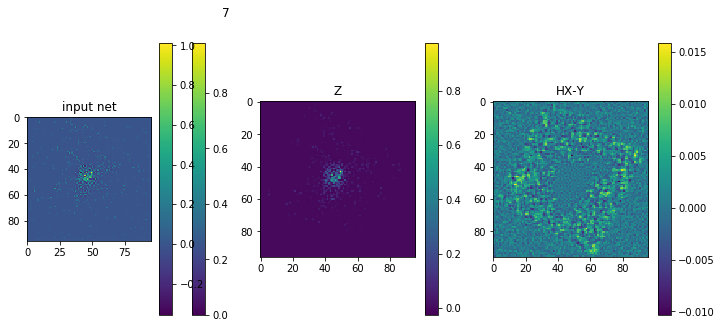

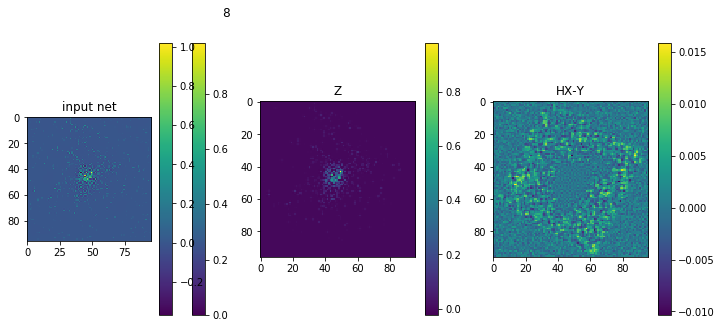

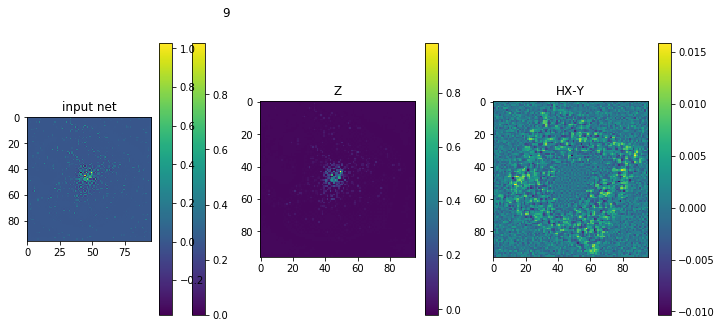

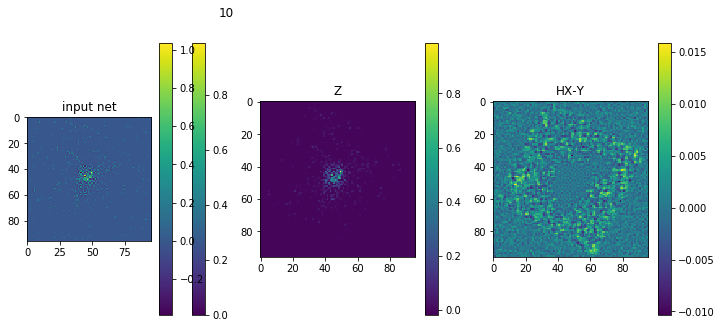

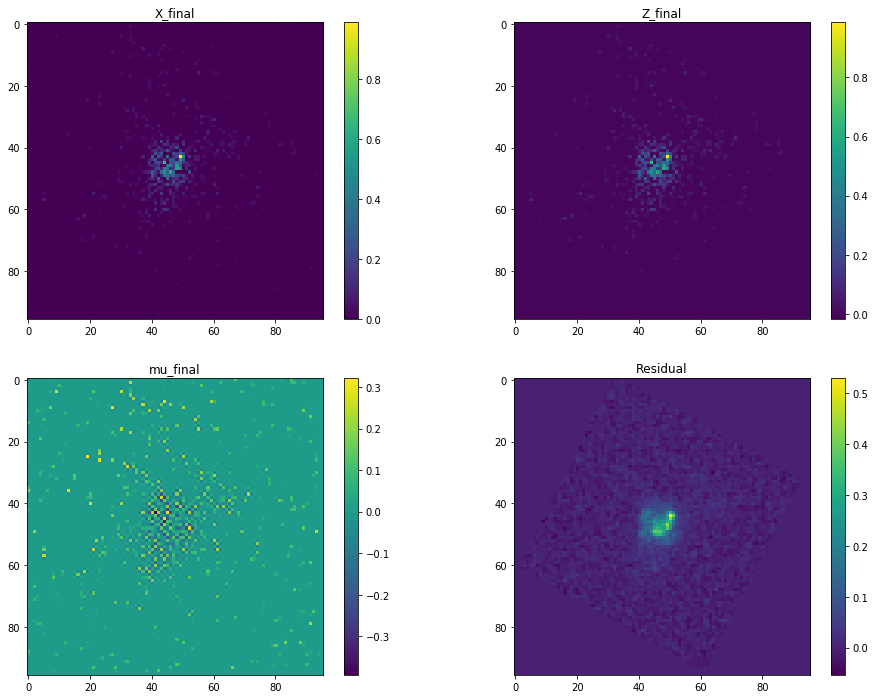

In [23]:
mu = np.zeros((96,96))
x = np.zeros((96,96))
z = np.zeros((96,96))
rho=1
rho_cap=rho
ad_al = ADMM(x, z, mu, observation, psf_rectr, noise_std, dnn, rho=rho, rho_cap=rho_cap, gamma=gamma, eta=eta,
                  opti_method="FISTA")

ad_al.iterate(max_iter=10, plot_iter=1, verbose=False, plot_verbose=True)
# verbose allows to print or not the cost function and the euclidean distance between X and Z
# plot_verbose allows or note to plot the images of X and Z at each iterations

# the output of the algorithm (the 3 variables) are directly stored as attributes.
plt.figure(figsize=(16,12))
plt.subplot(221)
plt.imshow(ad_al.x_final)
plt.title('X_final')
plt.colorbar()
plt.subplot(222)
plt.imshow(ad_al.z_final)
plt.title('Z_final')
plt.colorbar()
plt.subplot(223)
plt.imshow(ad_al.mu_final)
plt.title('mu_final')
plt.colorbar()
plt.subplot(224)
plt.imshow(target)
plt.title('Residual')
plt.colorbar()
plt.show()

Remark: our ground truths (GTs) are images convolved by a gaussian PSF of FWHM = 0.07 arcsec. Nowhere in this method it is taken into account, so we converge toward a sharper resolution than our GTs.

To take this PSF into account, it is necessary to do a pre-processing on the PSF before calling the ADMM.

In [9]:
from numpy.fft import fft2, ifft2, fftshift
from utils.conv_utils import perform_shift_in_frequency

#ADD GAUSSIAN PSF
psf_file = '/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits'
psf_gauss = fits.getdata(psf_file)
fft_gauss = fft2(psf_gauss)
fft = fft2(psf)
r = fft/fft_gauss
r[np.abs(fft_gauss)<1e-6] = 0
r = perform_shift_in_frequency(r, (96,96), np.array([1,1]))
psf = np.abs(fftshift(ifft2(r)))

ModuleNotFoundError: No module named 'utils'